In [144]:
import pandas as pd
import numpy as np

### Leitura dos dados

In [145]:
df = pd.read_csv("../data/daumau_clean_data.csv")

In [146]:
df.head(5)

,date,appId,dauReal,mauReal,month
0,2024-01-01,com.app.33540,393961.0,3643110.0,2024-01
1,2024-01-02,com.app.33540,800448.0,3643040.0,2024-01
2,2024-01-03,com.app.33540,754145.0,3634208.0,2024-01
3,2024-01-04,com.app.33540,794120.0,3634750.0,2024-01
4,2024-01-05,com.app.33540,891698.0,3650519.0,2024-01


### Análise exploratória

In [147]:
import seaborn as sns
import matplotlib.pyplot as plt

<Axes: xlabel='date', ylabel='dauReal'>

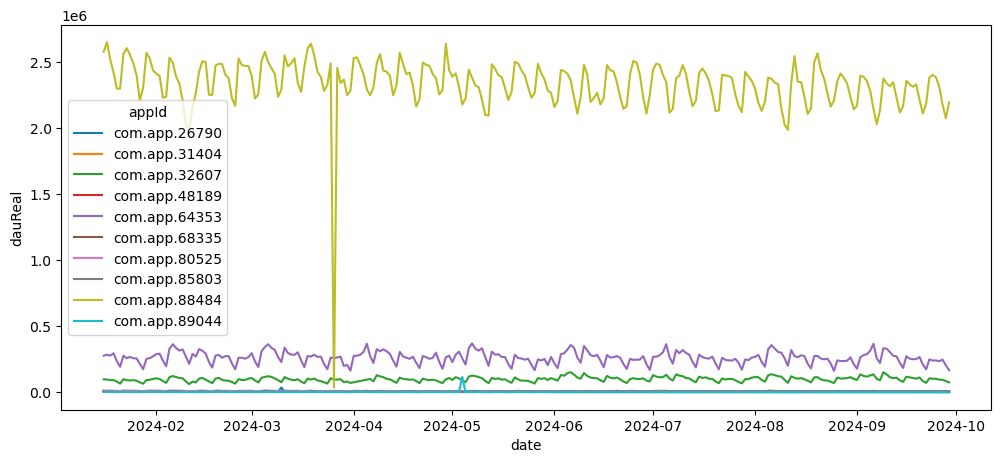

In [162]:
# visualizando x apps aleatórios
n = 10
sampled_apps = df["appId"].drop_duplicates().sample(n)

plt.figure(figsize=(12, 5))
plot_df = df[df["appId"].isin(sampled_apps)].copy().sort_values(["appId", "date"])
plot_df["date"] = pd.to_datetime(plot_df["date"])

sns.lineplot(
    data=plot_df, x="date", y="dauReal", hue="appId"
)

### Outliers

In [149]:
# no gráfico anterior pode-se observar alguns outliers, vou filtrá-los usando z-score
from scipy.stats import zscore

df['z'] = (
    df.groupby('appId')['dauReal']
      .transform(lambda s: zscore(s))
)

df['outlier_z'] = df['z'].abs() > 3 # assumindo uma distribuição normal, um z-score de 3 representa 99.73% da distribuição

In [150]:
# substituindo os outliers pela média

non_outlier_means = (
    df.loc[~df['outlier_z']]
      .groupby('appId')['dauReal']
      .mean()
)

df['mean_per_app'] = df['appId'].map(non_outlier_means)

df['dau_clean'] = np.where(df['outlier_z'],
                           df['mean_per_app'],
                           df['dauReal'])

### Feature engineering

In [151]:
# adicionando dias da semana
df["date"] = pd.to_datetime(df["date"])
df["weekday"] = df["date"].dt.dayofweek

# categorizando colunas
df['appId_cat'] = df['appId'].astype('category').cat.codes.astype('int32')
df['weekday_cat'] = df['weekday'].astype('category')
df['month_cat'] = df['date'].dt.month.astype('category')

# trazendo dau de dias anteriores para uma data específica e trazendo média e desvio móveis
def apply_metrics(df):

  df = df.sort_values('date').copy()
  
  for l in [1, 2, 3, 4, 5, 6, 7, 10, 15]:
      df[f'dau_lag_{l}'] = df['dau_clean'].shift(l)

  for w in [3, 15]:
        df[f'dau_roll_mean_{w}'] = df['dau_clean'].rolling(w).mean()
        df[f'dau_roll_std_{w}']  = df['dau_clean'].rolling(w).std()

  df["dau_avg"] = df['dau_clean'].mean()

  return df

df = df.groupby("appId", group_keys=False).apply(apply_metrics).dropna() # dias que não tem lags serão dropados

C:\Users\VitorSalladeMellos\AppData\Local\Temp\ipykernel_30816\2680148602.py:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby("appId", group_keys=False).apply(apply_metrics).dropna() # dias que não tem lags serão dropados


### Treinando o modelo

In [152]:
df = df.sort_values(by="date")

cat_cols = ['appId_cat', 'weekday_cat', 'month_cat']
num_cols = [c for c in df.columns if c.startswith(('dau_lag_', 'dau_roll_'))]

X = df[cat_cols + num_cols]
y = df['dau_clean']

split_date = df['date'].max() - pd.Timedelta(days=30)

train_mask = df['date'] < split_date

X_train, y_train = X.loc[train_mask], y.loc[train_mask]

In [ ]:
import xgboost as xgb 
# -------------------------------------------------------------------- 
# a escolha do xgboost se deu pela sua simplicidade e familiaridade
# outros modelos de séries temporais iriam exigir uma série temporal 
# para cada app
# -------------------------------------------------------------------- 

model = xgb.XGBRegressor(
    objective="reg:squarederror",
    learning_rate=0.1,
    max_depth=6,
    n_estimators=500,
    tree_method="hist",
    enable_categorical=True,
    verbosity=0
)

model.fit(
    X_train, y_train,
    verbose=False
)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=500,
             n_jobs=None, num_parallel_tree=None, ...)

### Gerando previsões

In [154]:
# calculando a previsão de forma iterativa, evitando leakages

import numpy as np
import seaborn as sns
from datetime import timedelta

app_id = 45
X_app_train  = X_train.loc[X_train["appId_cat"] == app_id].sort_index()
y_app_train  = y_train.loc[X_train["appId_cat"] == app_id].sort_index()

buf_y = list(y_app_train.tail(15).values)
last  = X_app_train.iloc[-1].copy()
last_date = df.loc[train_mask, "date"].max()

weekday_cats = df['weekday_cat'].cat.categories
month_cats   = df['month_cat'].cat.categories

df_forecast = pd.DataFrame(columns=["date", "appId_cat", "forecast"])
for step in range(1, 31):
    y_hat = model.predict(last.values.reshape(1, -1))[0]

    buf_y.append(y_hat)
    buf_y = buf_y[-15:]

    for lag in [1, 2, 3, 4, 5, 6, 7, 10, 15]:
        last[f"dau_lag_{lag}"] = buf_y[-lag]

    for w in [3, 15]:
        last[f"dau_roll_mean_{w}"] = np.mean(buf_y[-w:])
        last[f"dau_roll_std_{w}"]  = np.std(buf_y[-w:], ddof=0)

    last_date += timedelta(days=1)
    last['weekday_cat'] = pd.Categorical(
        [last_date.weekday()],
        categories=weekday_cats
    )[0]
    last['month_cat'] = pd.Categorical(
        [last_date.month],
        categories=month_cats
    )[0]

    df_forecast.loc[step - 1] = {
        "date":       last_date,
        "appId_cat":  app_id,
        "forecast":   y_hat
    }



df_forecast = df_forecast.merge(df[["date", "appId_cat", "dauReal"]], on=["date", "appId_cat"], how="left")

In [155]:
# aqui eu pedi pro chat generalizar o código anterior para todos app ids

import numpy as np
import pandas as pd
from datetime import timedelta

weekday_cats = df['weekday_cat'].cat.categories
month_cats   = df['month_cat'].cat.categories

all_preds = []

# ---------- LOOP PRINCIPAL ----------
for app_id in X_train['appId_cat'].unique():          # percorre todos os apps
    X_app_train = X_train.loc[X_train['appId_cat'] == app_id].sort_index()
    y_app_train = y_train.loc[X_train['appId_cat'] == app_id].sort_index()

    buf_y      = list(y_app_train.tail(15).values)
    last       = X_app_train.iloc[-1].copy()
    last_date  = df.loc[train_mask, 'date'].max()

    for step in range(1, 31):
        y_hat = model.predict(last.values.reshape(1, -1))[0]

        buf_y.append(y_hat)
        buf_y = buf_y[-15:]

        for lag in [1, 2, 3, 4, 5, 6, 7, 10, 15]:
            last[f"dau_lag_{lag}"] = buf_y[-lag]

        for w in [3, 15]:
            last[f"dau_roll_mean_{w}"] = np.mean(buf_y[-w:])
            last[f"dau_roll_std_{w}"]  = np.std(buf_y[-w:], ddof=0)

        last_date += timedelta(days=1)
        last['weekday_cat'] = pd.Categorical(
            [last_date.weekday()], categories=weekday_cats
        )[0]
        last['month_cat'] = pd.Categorical(
            [last_date.month], categories=month_cats
        )[0]

        all_preds.append({
            "date":      last_date,
            "appId_cat": app_id,
            "forecast":  y_hat
        })

# ---------- DATAFRAME FINAL ----------
df_forecast_all = pd.DataFrame(all_preds)

df_forecast_all = df_forecast_all.merge(
    df[["date", "appId", "appId_cat", "dauReal", "dau_avg"]],
    on=["date", "appId_cat"],
    how="left"
)


In [156]:
df_forecast_all.to_csv("../data/forecasts.csv")

### Exportando modelo

In [157]:
model.save_model("../models/xgb_model.bst")

c:\Users\VitorSalladeMellos\miniconda3\envs\case_data_science\Lib\site-packages\xgboost\sklearn.py:1028: UserWarning: [10:07:47] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\c_api\c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  self.get_booster().save_model(fname)
